In [2]:
import socket
import struct
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import glob, os

In [3]:
tdrDir = '/Users/HHG/FilesRepositories/AEDAT/TempFreq_bandpass/'
dataDir = tdrDir
os.chdir(dataDir)

datalist = glob.glob("N17in*")
dataread = []


for i in datalist:
    dataread.append(open(i,"rb"))
    debug = False

#print dataread

In [4]:
def read_events(file):
    """ A simple function that read dynap-se events from cAER aedat 3.0 file format"""
    
    # raise Exception at end of file
    data = file.read(28)
    if(len(data) <= 0):
        print("read all data\n")
        raise NameError('END OF DATA')


    # read header
    eventtype = struct.unpack('H', data[0:2])[0]
    eventsource = struct.unpack('H', data[2:4])[0]
    eventsize = struct.unpack('I', data[4:8])[0]
    eventoffset = struct.unpack('I', data[8:12])[0]
    eventtsoverflow = struct.unpack('I', data[12:16])[0]
    eventcapacity = struct.unpack('I', data[16:20])[0]
    eventnumber = struct.unpack('I', data[20:24])[0]
    eventvalid = struct.unpack('I', data[24:28])[0]
    next_read = eventcapacity * eventsize  # we now read the full packet
    data = file.read(next_read)    
    counter = 0  # eventnumber[0]
    #spike events
    core_id_tot = []
    chip_id_tot = []
    neuron_id_tot = []
    ts_tot =[]
    #special events
    spec_type_tot =[]
    spec_ts_tot = []

    if(eventtype == 0):
        spec_type_tot =[]
        spec_ts_tot = []
        while(data[counter:counter + eventsize]):  # loop over all event packets
            special_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            spec_type = (special_data >> 1) & 0x0000007F
            spec_type_tot.append(spec_type)
            spec_ts_tot.append(timestamp)
            if(spec_type == 6 or spec_type == 7 or spec_type == 9 or spec_type == 10):
                print (timestamp, spec_type)
            counter = counter + eventsize        
    elif(eventtype == 12):
        while(data[counter:counter + eventsize]):  # loop over all event packets
            aer_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            core_id = (aer_data >> 1) & 0x0000001F
            chip_id = (aer_data >> 6) & 0x0000003F
            neuron_id = (aer_data >> 12) & 0x000FFFFF
            core_id_tot.append(core_id)
            chip_id_tot.append(chip_id)
            neuron_id_tot.append(neuron_id)
            ts_tot.append(timestamp)
            counter = counter + eventsize
            if(debug):          
                print("chip id "+str(chip_id)+'\n')
                print("core_id "+str(core_id)+'\n')
                print("neuron_id "+str(neuron_id)+'\n')
                print("timestamp "+str(timestamp)+'\n')
                print("####\n")


    return core_id_tot, chip_id_tot, neuron_id_tot, ts_tot, spec_type_tot, spec_ts_tot

In [5]:
def skip_header(file):
    ''' This function skip the standard header of the recording file '''
    line = file.readline()
    while line.startswith("#"):
        if ( line == '#!END-HEADER\r\n'):
            break
        else:
            line = file.readline()

In [6]:
done_reading = [False,False,False,False,False]

for data in dataread:
    skip_header(data)
    
times_17 = []
times_154 = []
neuron_17 = []
neuron_154 = []

for i in range(len(dataread)):
    chip_id_tot = []
    core_id_tot = []
    neuron_id_tot = []
    ts_tot  = []
    spec_type_tot = []
    spec_ts_tot = []
    while(done_reading[i] == False):
        try:
            core_id, chip_id, neuron_id, ts, spec_type, spec_ts = read_events(dataread[i])
            core_id_tot.extend(np.array(core_id))
            chip_id_tot.extend(np.array(chip_id))
            neuron_id_tot.extend(np.array(neuron_id))
            ts_tot.extend(np.array(ts))
            spec_type_tot.extend(np.array(spec_type))
            spec_ts_tot.extend(np.array(spec_ts))
                    
        except NameError:
            dataread[i].close()
            done_reading[i] = True
    neuron_id_d = []
    ts_id_d = []
    for chip, core, neur, ts in zip(chip_id_tot, core_id_tot, neuron_id_tot, ts_tot):
        if chip == 1 and core == 2:
            neuron_id_d.append(neur)
            ts_id_d.append(ts)
        if chip == 1 and core == 1:
            neuron_id_d.append(neur)
            ts_id_d.append(ts)
    times_17.append(ts_tot[-1]-ts_tot[0])
    neuron_17.append(neuron_id_d.count(17))
    times_154.append(ts_tot[-1]-ts_tot[0])
    neuron_154.append(neuron_id_d.count(154))
        

read all data

read all data

read all data

read all data

read all data



In [7]:
activity_17 = []
activity_154 = []

times_17sec = [i*(10**-6) for i in times_17]
times_154sec = [i*(10**-6) for i in times_154]

for i,count in enumerate(neuron_17):
    activity_17.append(count/times_17sec[i])
print activity_17

for i,count in enumerate(neuron_154):
    activity_154.append(count/times_154sec[i])
print activity_154


[3.7300588390138576, 6.859258603195018, 8.8727524390796457, 1.9174916698787072, 1.3234522155754729]
[0.0, 0.0, 0.0, 8.1348131449399705, 8.3112799138139692]


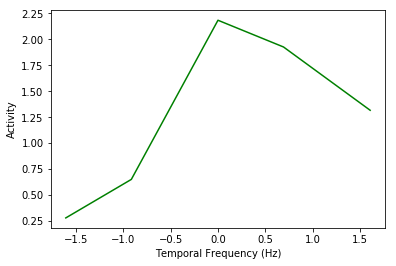

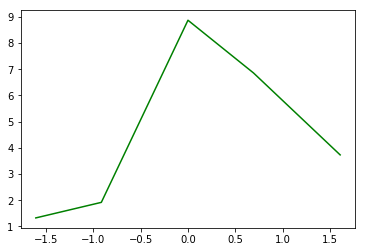

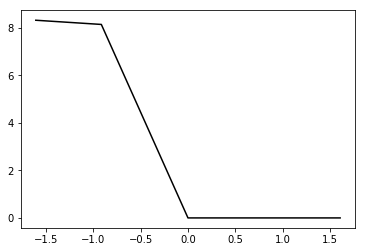

In [8]:
freq = [5,2,1,0.4,0.2]
plt.clf()
fig1 = plt.figure()
plt.plot(np.log(freq), np.log(activity_17), 'g-')
#plt.plot(np.log(freq),(activity_154), 'kx')
plt.ylabel('Activity')    
plt.xlabel('Temporal Frequency (Hz)')

#fig4 = plt.figure()
#plt.plot(spatial)